# pyQuPath: Python Utilities for QuPath

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from IPython.core.interactiveshell import InteractiveShell

from pyqupath.color import (
    assign_bright_colors,
    create_colormap,
    generate_distinct_colors,
)
from pyqupath.geojson import GeojsonProcessor, PolygonProcessor
from pyqupath.tiff import PyramidWriter, TiffZarrReader

InteractiveShell.ast_node_interactivity = "all"

/mnt/nfs/home/wenruiwu/projects/pyqupath/.pixi/envs/default/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## `tiff` module

### 01. Pyramidal OME-TIFF Writer

Supports multi-resolution pyramid generation, parallel processing, progress tracking, and flexible input formats

- `PyramidWriter`: A class for generating pyramidal OME-TIFF files with these features:
    - Factory methods:
        - `from_array()`: Create writer from numpy/zarr array
        - `from_dict()`: Create writer from dictionary of arrays
        - `from_fs()`: Create writer from file system paths
    - Methods:
        - `export_ometiff_pyramid()`: Generate pyramidal OME-TIFF with customizable parameters

In [2]:
# 2d pyramidal ome-tiff
img = tifffile.imread("data/tiff/DAPI.tiff")
print(img.shape)

tiff_writer = PyramidWriter.from_array(img, channel_names=["DAPI"])
tiff_writer.export_ometiff_pyramid("data/ometiff/2d_pyramid.ome.tiff")

(5472, 5952)
Overwriting existing file: data/ometiff/2d_pyramid.ome.tiff


Writing tiles: 100%|██████████| 710/710 [00:00<00:00, 1657.87it/s]


In [3]:
# 3d pyramidal ome-tiff from dictionary
img_dict = {}
for marker in ["DAPI", "CD45", "CD3e", "CD4", "CD8"]:
    img = tifffile.imread(f"data/tiff/{marker}.tiff")
    img_dict[marker] = img
    print(marker, img.shape)

tiff_writer = PyramidWriter.from_dict(img_dict)
tiff_writer.export_ometiff_pyramid("data/ometiff/3d_pyramid_1.ome.tiff")


DAPI (5472, 5952)
CD45 (5472, 5952)
CD3e (5472, 5952)
CD4 (5472, 5952)
CD8 (5472, 5952)
Overwriting existing file: data/ometiff/3d_pyramid_1.ome.tiff


Writing tiles: 100%|██████████| 710/710 [00:01<00:00, 467.23it/s]


In [4]:
# 3d pyramidal ome-tiff from file list
files = []
markers = ["DAPI", "CD45", "CD3e", "CD4", "CD8"]
for marker in markers:
    files.append(f"data/tiff/{marker}.tiff")

tiff_writer = PyramidWriter.from_fs(files, channel_names=markers)
tiff_writer.export_ometiff_pyramid("data/ometiff/3d_pyramid_2.ome.tiff")


Loading images: 100%|██████████| 5/5 [00:00<00:00, 14.36it/s]


Overwriting existing file: data/ometiff/3d_pyramid_2.ome.tiff


Writing tiles: 100%|██████████| 710/710 [00:01<00:00, 466.92it/s] 


### 02. TIFF Reader

Lazy loading of images using zarr, support for both OME-TIFF and QPTIFF formats, channel-based indexing, and region-based loading

- `TiffZarrReader`: A class for efficient reading of TIFF files with these features:
    - Factory methods:
        - `from_ometiff()`: Create reader from OME-TIFF file
        - `from_qptiff()`: Create reader from QPTIFF file
    - Properties:
        - `zimg`: The image as a zarr array
        - `zimg_dict`: The image as a dictionary of zarr arrays
        - `channel_names`: The names of the channels

<zarr.core.Array (5, 5472, 5952) uint16>
{'channel_0': <zarr.core.Array (5472, 5952) uint16>, 'channel_1': <zarr.core.Array (5472, 5952) uint16>, 'channel_2': <zarr.core.Array (5472, 5952) uint16>, 'channel_3': <zarr.core.Array (5472, 5952) uint16>, 'channel_4': <zarr.core.Array (5472, 5952) uint16>}
['channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4']


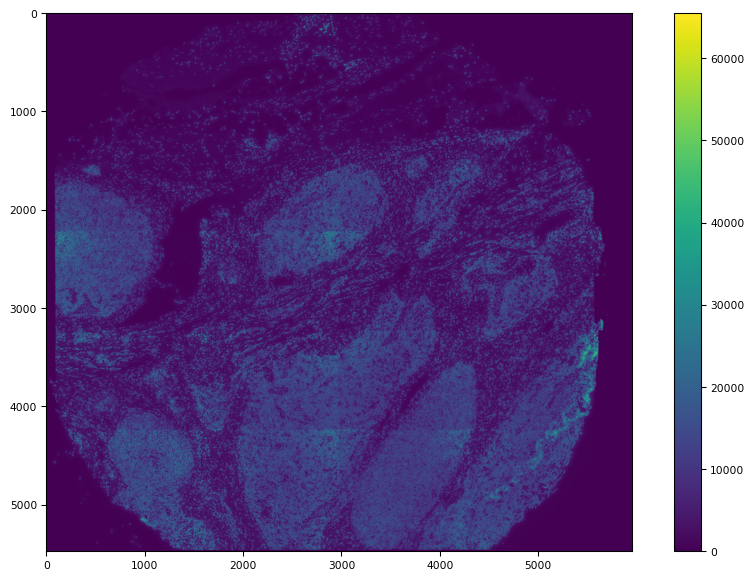

In [5]:
# not parse ome-tiff metadata for channel names
tiff_reader = TiffZarrReader("data/ometiff/3d_pyramid_1.ome.tiff")
print(tiff_reader.zimg)
print(tiff_reader.zimg_dict)
print(tiff_reader.channel_names)

tifffile.imshow(tiff_reader.zimg_dict["channel_0"][:]);

<zarr.core.Array (5, 5472, 5952) uint16>
{'DAPI': <zarr.core.Array (5472, 5952) uint16>, 'CD45': <zarr.core.Array (5472, 5952) uint16>, 'CD3e': <zarr.core.Array (5472, 5952) uint16>, 'CD4': <zarr.core.Array (5472, 5952) uint16>, 'CD8': <zarr.core.Array (5472, 5952) uint16>}
['DAPI', 'CD45', 'CD3e', 'CD4', 'CD8']


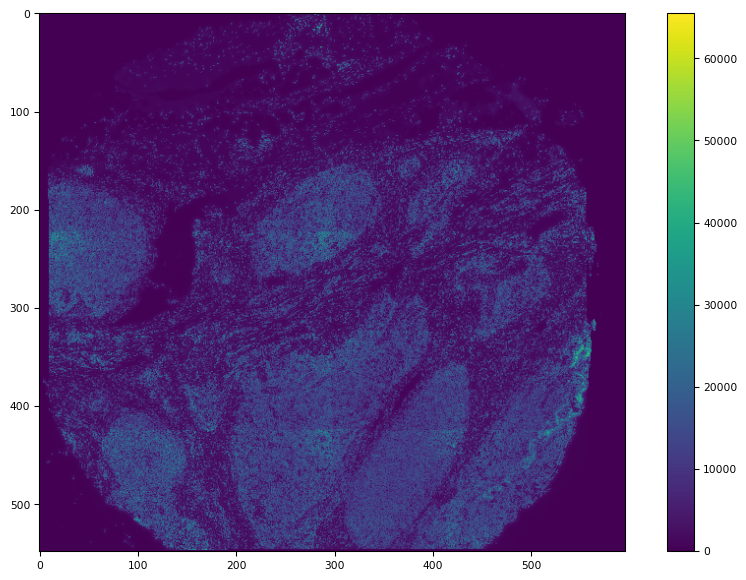

In [6]:
# parse ome-tiff metadata for channel names
tiff_reader = TiffZarrReader.from_ometiff("data/ometiff/3d_pyramid_1.ome.tiff")
print(tiff_reader.zimg)
print(tiff_reader.zimg_dict)
print(tiff_reader.channel_names)

tifffile.imshow(tiff_reader.zimg_dict["DAPI"][::10, ::10]);

In [7]:
# Pyramidal OME-TIFF Writer for zarr.core.Array
tiff_reader = TiffZarrReader.from_ometiff("data/ometiff/3d_pyramid_1.ome.tiff")
print(tiff_reader.zimg_dict)

PyramidWriter.from_dict(tiff_reader.zimg_dict).export_ometiff_pyramid(
    "data/ometiff/3d_pyramid_3.ome.tiff"
)

{'DAPI': <zarr.core.Array (5472, 5952) uint16>, 'CD45': <zarr.core.Array (5472, 5952) uint16>, 'CD3e': <zarr.core.Array (5472, 5952) uint16>, 'CD4': <zarr.core.Array (5472, 5952) uint16>, 'CD8': <zarr.core.Array (5472, 5952) uint16>}


Overwriting existing file: data/ometiff/3d_pyramid_3.ome.tiff


Writing tiles: 100%|██████████| 710/710 [00:01<00:00, 451.91it/s] 


## `geojson` module

### 01. GeoJSON IO and Processing

- `GeojsonProcessor`: A class for reading and manipulating GeoJSON files
    - Factory methods:
        - `from_path()`: Create processor from GeoJSON file
        - `from_text()`: Create processor from GeoJSON text
    - Properties:
        - `gdf`: The GeoDataFrame containing the GeoJSON data
        - `gdf_raw`: The raw GeoDataFrame before polygon filtering
    - Methods:
        - `set_index()`: Set index with duplicate handling
        - `plot_classification()`: Plot classifications with legend
        - `update_classification()`: Update classification names and colors
        - `output_geojson()`: Output the GeoDataFrame as a GeoJSON file
        - `crop_array_by_polygons()`: Crop an image using polygons in the GeoDataFrame
        - `crop_dict_by_polygons()`: Crop a dictionary of images by polygons in the GeoDataFrame

#### Load GeoJSON

In [8]:
# load all geometries
geojson_processor = GeojsonProcessor.from_path(
    "data/geojson/test.geojson", polygon_only=False
)

# geopandas dataframe
geojson_processor.gdf_raw  # without renaming duplicated names
geojson_processor.gdf  # with renaming duplicated names

Duplicate values found:
3    2
Name: name, dtype: int64


,id,objectType,name,geometry,classification
0,b0ebe3a3-0113-48ad-b95b-081cf1ed1bde,annotation,1,"POLYGON ((2815 1974, 2814.34 1995.03, 2812.36 ...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
1,9e0958a7-28ba-4ad8-83d1-32d7d4bd6570,annotation,3,"LINESTRING (1114.19 2372.09, 864.72 2149.15, 5...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
2,7eeee1dd-a370-42ee-aa13-173bf5417b94,annotation,4,"LINESTRING (3399.77 3029.19, 3572.36 3253.55, ...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
3,7162e22f-2392-41bd-a312-a39fc563cb45,annotation,3,"MULTIPOLYGON (((4607.05 2722.98, 4420 2578, 42...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
4,f57bcff9-6dba-4fe5-bd36-31fa77ce092a,annotation,2,"MULTIPOLYGON (((3760.5 2057.11, 3753 2060, 375...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"


,id,objectType,name,geometry,classification
1,b0ebe3a3-0113-48ad-b95b-081cf1ed1bde,annotation,1,"POLYGON ((2815 1974, 2814.34 1995.03, 2812.36 ...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
3_1,9e0958a7-28ba-4ad8-83d1-32d7d4bd6570,annotation,3,"LINESTRING (1114.19 2372.09, 864.72 2149.15, 5...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
4,7eeee1dd-a370-42ee-aa13-173bf5417b94,annotation,4,"LINESTRING (3399.77 3029.19, 3572.36 3253.55, ...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
3_2,7162e22f-2392-41bd-a312-a39fc563cb45,annotation,3,"MULTIPOLYGON (((4607.05 2722.98, 4420 2578, 42...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
2,f57bcff9-6dba-4fe5-bd36-31fa77ce092a,annotation,2,"MULTIPOLYGON (((3760.5 2057.11, 3753 2060, 375...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"


In [9]:
# load only polygon geometries
geojson_processor_polygon = GeojsonProcessor.from_path(
    "data/geojson/test.geojson", polygon_only=True
)

Skipping LineString: end distance 172.92 > 50.00
Fixing LineString: end distance 1.94 <= 50.00
Skipping MultiPolygon: area ratio 1.02 < 100.00
Fixing MultiPolygon: area ratio 3716.83 >= 100.00
Skipped 2 geometries: 
    LINESTRING (1114.19 2372.09, 864.72 2149.15, 599.58 2419.42, 847.4 2657.25, 1102.25 2544.6)
    MULTIPOLYGON (((4607.05 2722.98, 4420 2578, 4253 2654, 4377 2775, 4528 2799, 4607.05 2722.98)), ((4893 2448, 4607.05 2722.98, 4669 2771, 4985 2569, 4893 2448)))


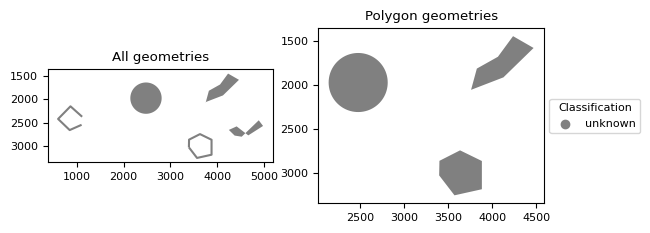

In [10]:
# plot geometries
fig, axs = plt.subplots(1, 2)
axs[0].set_title("All geometries")
geojson_processor.plot_classification(ax=axs[0], legend=False)
axs[1].set_title("Polygon geometries")
geojson_processor_polygon.plot_classification(ax=axs[1]);

Skipping LineString: end distance 172.92 > 50.00
Fixing LineString: end distance 1.94 <= 50.00
Skipping MultiPolygon: area ratio 1.02 < 100.00
Fixing MultiPolygon: area ratio 3716.83 >= 100.00
Skipped 2 geometries: 
    LINESTRING (1114.19 2372.09, 864.72 2149.15, 599.58 2419.42, 847.4 2657.25, 1102.25 2544.6)
    MULTIPOLYGON (((4607.05 2722.98, 4420 2578, 4253 2654, 4377 2775, 4528 2799, 4607.05 2722.98)), ((4893 2448, 4607.05 2722.98, 4669 2771, 4985 2569, 4893 2448)))


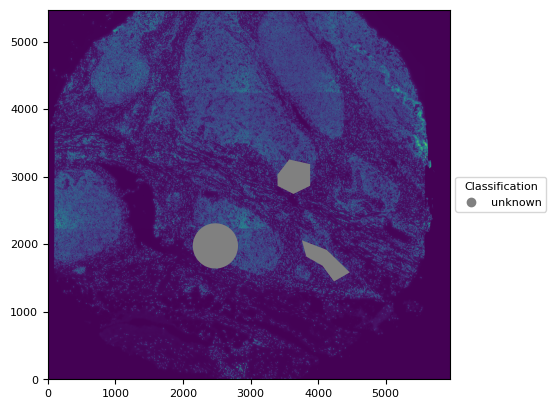

In [11]:
# plot geometries on image
tiff_reader = TiffZarrReader.from_ometiff("data/ometiff/3d_pyramid_1.ome.tiff")

fig, ax = plt.subplots(1, 1)
ax.imshow(tiff_reader.zimg_dict["DAPI"])
GeojsonProcessor.from_path("data/geojson/test.geojson").plot_classification(ax=ax);

#### Update GeoJSON

Skipping LineString: end distance 172.92 > 50.00
Fixing LineString: end distance 1.94 <= 50.00
Skipping MultiPolygon: area ratio 1.02 < 100.00
Fixing MultiPolygon: area ratio 3716.83 >= 100.00
Skipped 2 geometries: 
    LINESTRING (1114.19 2372.09, 864.72 2149.15, 599.58 2419.42, 847.4 2657.25, 1102.25 2544.6)
    MULTIPOLYGON (((4607.05 2722.98, 4420 2578, 4253 2654, 4377 2775, 4528 2799, 4607.05 2722.98)), ((4893 2448, 4607.05 2722.98, 4669 2771, 4985 2569, 4893 2448)))
1    1
4    4
2    2
Name: name, dtype: object


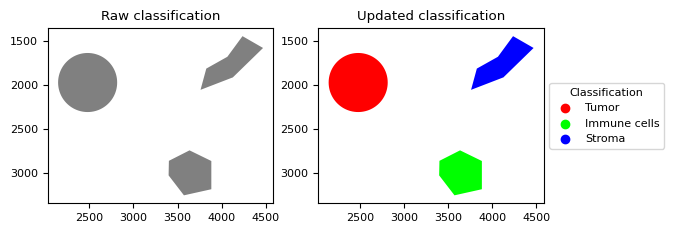

In [12]:
geojson_processor = GeojsonProcessor.from_path("data/geojson/test.geojson")
print(geojson_processor.gdf.name)

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Raw classification")
geojson_processor.plot_classification(ax=axs[0], legend=False)

name_dict = {"1": "Tumor", "2": "Stroma", "4": "Immune cells"}
geojson_processor.update_classification(name_dict)
axs[1].set_title("Updated classification")
geojson_processor.plot_classification(ax=axs[1]);

Skipping LineString: end distance 172.92 > 50.00
Fixing LineString: end distance 1.94 <= 50.00
Skipping MultiPolygon: area ratio 1.02 < 100.00
Fixing MultiPolygon: area ratio 3716.83 >= 100.00
Skipped 2 geometries: 
    LINESTRING (1114.19 2372.09, 864.72 2149.15, 599.58 2419.42, 847.4 2657.25, 1102.25 2544.6)
    MULTIPOLYGON (((4607.05 2722.98, 4420 2578, 4253 2654, 4377 2775, 4528 2799, 4607.05 2722.98)), ((4893 2448, 4607.05 2722.98, 4669 2771, 4985 2569, 4893 2448)))
Skipped 0 geometries: 


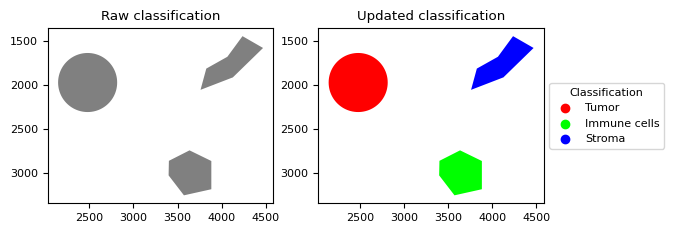

In [13]:
geojson_processor.output_geojson("data/geojson/test_updated.geojson")

fig, axs = plt.subplots(1, 2)
GeojsonProcessor.from_path("data/geojson/test.geojson").plot_classification(
    ax=axs[0], legend=False
)
axs[0].set_title("Raw classification")
GeojsonProcessor.from_path("data/geojson/test_updated.geojson").plot_classification(
    ax=axs[1]
)
axs[1].set_title("Updated classification");

#### Crop Region with GeoJSON

Skipping LineString: end distance 172.92 > 50.00
Fixing LineString: end distance 1.94 <= 50.00
Skipping MultiPolygon: area ratio 1.02 < 100.00
Fixing MultiPolygon: area ratio 3716.83 >= 100.00
Skipped 2 geometries: 
    LINESTRING (1114.19 2372.09, 864.72 2149.15, 599.58 2419.42, 847.4 2657.25, 1102.25 2544.6)
    MULTIPOLYGON (((4607.05 2722.98, 4420 2578, 4253 2654, 4377 2775, 4528 2799, 4607.05 2722.98)), ((4893 2448, 4607.05 2722.98, 4669 2771, 4985 2569, 4893 2448)))


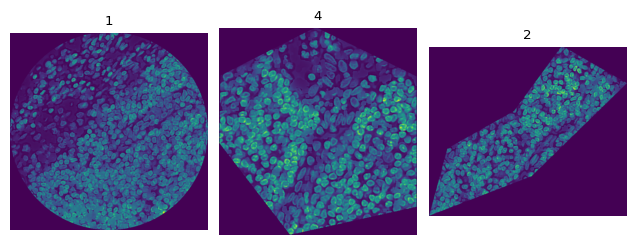

In [14]:
geojson_processor = GeojsonProcessor.from_path("data/geojson/test.geojson")
tiff_reader = TiffZarrReader.from_ometiff("data/ometiff/3d_pyramid_1.ome.tiff")

# for name, img in geojson_processor.crop_dict_by_polygons(tiff_reader.zimg_dict):

fig, axs = plt.subplots(1, len(geojson_processor.gdf))
for i, (name, crop_img_dict) in enumerate(
    geojson_processor.crop_dict_by_polygons(tiff_reader.zimg_dict, fill_value=0)
):
    axs[i].imshow(crop_img_dict["DAPI"])
    axs[i].set_title(name)
    axs[i].axis("off")
plt.tight_layout();

### 02. Polygon Processing

- `PolygonProcessor`: A class for processing polygon geometries
    - Methods:
        - `fix_geometry_to_polygon()`: Fix geometries that should be Polygon but were incorrectly annotated as other types
        - `polygon_to_mask()`: Generate a binary mask from a polygon
        - `crop_array_by_polygon()`: Crop an image using a polygon and apply a mask
    - Supports:
        - Converting MultiPolygon to largest Polygon if area ratio exceeds threshold
        - Converting LineString to Polygon if endpoints are close enough
        - Filtering invalid geometries

#### Fix Geometry

Duplicate values found:
3    2
Name: name, dtype: int64


,id,objectType,name,geometry,classification
1,b0ebe3a3-0113-48ad-b95b-081cf1ed1bde,annotation,1,"POLYGON ((2815 1974, 2814.34 1995.03, 2812.36 ...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
3_1,9e0958a7-28ba-4ad8-83d1-32d7d4bd6570,annotation,3,"LINESTRING (1114.19 2372.09, 864.72 2149.15, 5...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
4,7eeee1dd-a370-42ee-aa13-173bf5417b94,annotation,4,"LINESTRING (3399.77 3029.19, 3572.36 3253.55, ...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
3_2,7162e22f-2392-41bd-a312-a39fc563cb45,annotation,3,"MULTIPOLYGON (((4607.05 2722.98, 4420 2578, 42...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"
2,f57bcff9-6dba-4fe5-bd36-31fa77ce092a,annotation,2,"MULTIPOLYGON (((3760.5 2057.11, 3753 2060, 375...","{""name"": ""unknown"", ""color"": [128, 128, 128]}"


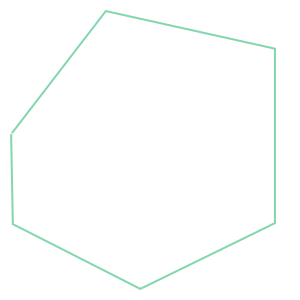

<bound method BaseGeometry.geometryType of <LINESTRING (3399.77 3029.19, 3572.36 3253.55, 3883.01 3184.52, 3883.01 2864...>>


In [15]:
geojson_processor = GeojsonProcessor.from_path(
    "data/geojson/test.geojson", polygon_only=False
)
geojson_processor.gdf

polygon = geojson_processor.gdf.loc["4", "geometry"]
polygon
print(polygon.geometryType)

Fixing LineString: end distance 1.94 <= 50.00


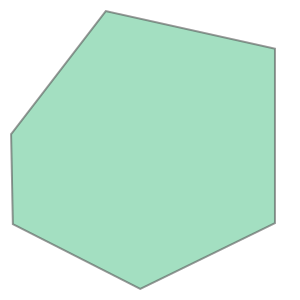

<bound method BaseGeometry.geometryType of <LINESTRING (3399.77 3029.19, 3572.36 3253.55, 3883.01 3184.52, 3883.01 2864...>>


In [16]:
polygon_fix = PolygonProcessor.fix_geometry_to_polygon(polygon)
polygon_fix
print(polygon.geometryType)

#### Polygon to MasK

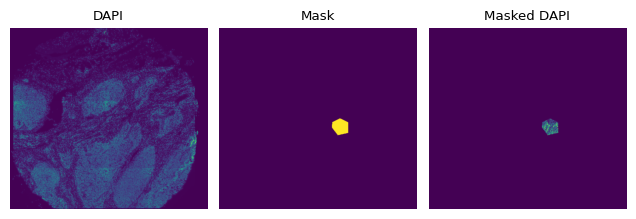

In [17]:
tiff_reader = TiffZarrReader.from_ometiff("data/ometiff/3d_pyramid_1.ome.tiff")
mask = PolygonProcessor.polygon_to_mask(polygon_fix, tiff_reader.zimg.shape[1:])

fig, axs = plt.subplots(1, 3)
for ax in axs:
    ax.axis("off")
axs[0].imshow(tiff_reader.zimg_dict["DAPI"][::10, ::10])
axs[0].set_title("DAPI")
axs[1].imshow(mask[::10, ::10])
axs[1].set_title("Mask")
axs[2].imshow(tiff_reader.zimg_dict["DAPI"][::10, ::10] * mask[::10, ::10])
axs[2].set_title("Masked DAPI")
fig.tight_layout();

### 03. Mask Conversion

- `binary_mask_to_polygon()`: Convert a binary mask to a Shapely Polygon
- `mask_to_polygon_batch()`: Convert a batch of labels from a mask into Polygons
- `mask_to_polygons()`: Convert a segmentation mask into a list of Polygons
- `mask_to_geojson()`: Convert a labeled mask into a GeoJSON file with optional simplification
- `mask_to_geojson_joblib()`: Convert a labeled mask into a GeoJSON file using parallel processing

Skipping LineString: end distance 172.92 > 50.00
Fixing LineString: end distance 1.94 <= 50.00
Skipping MultiPolygon: area ratio 1.02 < 100.00
Fixing MultiPolygon: area ratio 3716.83 >= 100.00
Skipped 2 geometries: 
    LINESTRING (1114.19 2372.09, 864.72 2149.15, 599.58 2419.42, 847.4 2657.25, 1102.25 2544.6)
    MULTIPOLYGON (((4607.05 2722.98, 4420 2578, 4253 2654, 4377 2775, 4528 2799, 4607.05 2722.98)), ((4893 2448, 4607.05 2722.98, 4669 2771, 4985 2569, 4893 2448)))


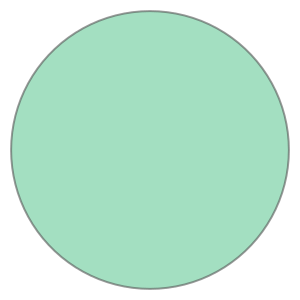

In [18]:
geojson_processor = GeojsonProcessor.from_path("data/geojson/test.geojson")
polygon = geojson_processor.gdf.loc["1", "geometry"]
polygon

/mnt/nfs/home/wenruiwu/projects/pyqupath/.pixi/envs/default/lib/python3.10/site-packages/tifffile/tifffile.py:25102: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pyplot.Slider(


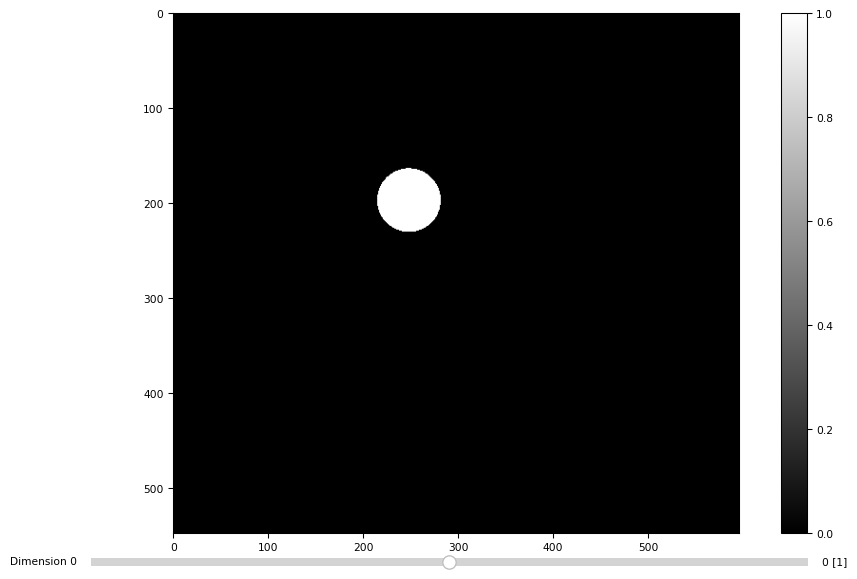

In [19]:
tiff_reader = TiffZarrReader.from_ometiff("data/ometiff/3d_pyramid_1.ome.tiff")
mask = PolygonProcessor.polygon_to_mask(polygon, tiff_reader.zimg.shape[1:])
tifffile.imshow(mask[::10, ::10]);

## `color` module
- `generate_distinct_colors`: Generate n visually distinct colors using HSV color space.
- `def assign_bright_colors`: Assign bright RGB colors to given values.
- `create_colormap`: Create a colormap from a list of RGB colors with interpolation.

In [20]:
# generate distinct colors
colors5 = generate_distinct_colors(5)
print("5 distinct colors:", colors5)
colors10 = generate_distinct_colors(10)
print("10 distinct colors:", colors10)

5 distinct colors: [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
10 distinct colors: [(242, 72, 72), (72, 122, 242), (171, 242, 72), (242, 72, 221), (72, 242, 213), (242, 164, 72), (114, 72, 242), (79, 242, 72), (242, 72, 129), (72, 178, 242)]


In [21]:
# assign colors to labels
cell_types = ["Tumor", "Stroma", "Immune", "Necrosis", "Normal"]
color_dict = assign_bright_colors(cell_types)

print("Color assignments:")
for label, color in color_dict.items():
    print(f"{label}: RGB{color}")

Color assignments:
Tumor: RGB(255, 0, 0)
Stroma: RGB(0, 255, 0)
Immune: RGB(0, 0, 255)
Necrosis: RGB(255, 255, 0)
Normal: RGB(255, 0, 255)


In [22]:
# rainbow colormap
rainbow_colors = [
    (255, 0, 0),  # Red
    (255, 165, 0),  # Orange
    (255, 255, 0),  # Yellow
    (0, 255, 0),  # Green
    (0, 0, 255),  # Blue
    (148, 0, 211),  # Violet
]
rainbow_map = create_colormap("Rainbow", rainbow_colors)

# sample colors at different values
rainbow_samples = [
    rainbow_map._unpack_rgb(rainbow_map.get_color(value, 0, 1))
    for value in np.linspace(0, 1, 10)
]
print(f"{rainbow_map.name} gradient at different values:")
for value, color in zip(np.linspace(0, 1, 10), rainbow_samples):
    print(f"{value:.2f}: {color}")


Rainbow gradient at different values:
0.00: (255, 0, 0)
0.11: (255, 90, 0)
0.22: (255, 175, 0)
0.33: (255, 224, 0)
0.44: (203, 255, 0)
0.56: (58, 255, 0)
0.67: (0, 174, 81)
0.78: (0, 34, 221)
0.89: (64, 0, 236)
1.00: (148, 0, 211)
